In [1]:
import time
import queue
from threading import Thread

from evaluate_fitness import load_training_data
from genetic_algorithm import genetic_algorithm
from solution import Solution
from tree import Tree


training_data = load_training_data("data/cetdl1772small.dat")


class Flag:
    def __init__(self):
        self._set = False
    
    def set(self):
        self._set = True
    
    def __bool__(self):
        return self._set

# Calculating Parameters

To fulfill the needs of the experiment we need to run each parameter setting, for each parameter, 100 times.

Choosing (fairly conservatively):
* Time budget of 20 seconds
* 3 parameters to alter
* 4 values for each parameter

This gives a runtime of $ 3 * 4 * 20 * 100 = 24000 $ seconds, or $8.5$ hours. Clearly we need to use some parallelism to get results in any reasonable timeframe.

In [2]:
def run_test(time_budget=20, pop_size=100, input_size=-1, iterations=2**100, 
             fraction_parents=0.1, p_simplify=0.01, num_sweeps=3, wrong_choice=0.4,
             mutation_crossover_ratio=0.5, mutation_replacement_ratio=0.5):

    # Perform the GA in a separate thread.
    stop_flag = Flag()
    results_queue = queue.LifoQueue()
    target = lambda: genetic_algorithm(
        pop_size, input_size, iterations, training=training_data, results_queue=results_queue,
        stop_flag=stop_flag,
        p_simplify=p_simplify, num_sweeps=num_sweeps, wrong_choice=wrong_choice,
        mutation_crossover_ratio=mutation_crossover_ratio, fraction_parents=fraction_parents,
        mutation_replacement_ratio=mutation_replacement_ratio
    )
    computation_thread = Thread(target=target, daemon=True)  # Allow exiting when the timer runs out.
    computation_thread.start()

    # Wait `time_budget` seconds, then take the latest result.
    time.sleep(time_budget-0.1)
    best = results_queue.get_nowait()
    stop_flag.set()

    fitness = best.evaluate_fitness_against(training_data)
    return fitness

In [3]:
import time
import statistics as stats
from multiprocessing import Pool

# Default arguments for test runner.
args = {
    "fraction_parents": 0.2,
    "p_simplify": 0.01,
    "num_sweeps": 3,
    "wrong_choice": 0.4,
    "mutation_crossover_ratio": 0.5,
    "mutation_replacement_ratio": 0.5
}


ITERATIONS = 3
WORKERS = 8
pool = Pool(WORKERS)

# Test Parameter: Fraction of Parents from Population

In [4]:
from test_runners import test_runner
start = time.perf_counter()

parent_fraction_results = {}
for fraction in (0.1, 0.2, 0.3, 0.4):
    fitnesses = list(pool.imap_unordered(
        test_runner,
        ((run_test, {**args, "fraction_parents": fraction}) for _ in range(ITERATIONS))
    ))
    stddev = stats.stdev(fitnesses)
    mean = stats.mean(fitnesses)
    parent_fraction_results[fraction] = (fitnesses, stddev, mean)

print(f"Running {4 * ITERATIONS} tests at 20s each on {WORKERS} workers took {(time.perf_counter() - start):.1f}s")

Running 12 tests at 20s each on 8 workers took 82.3s


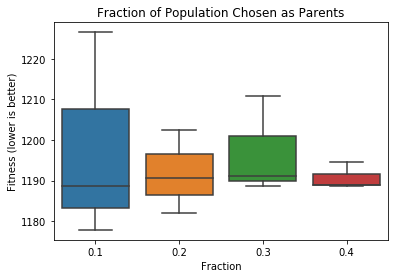

In [5]:
from seaborn import boxplot

data = [
    v[0] for v in (parent_fraction_results[k] 
        for k in sorted(parent_fraction_results.keys()))
]

_ = boxplot(data=data).set(
    xlabel="Fraction",
    ylabel="Fitness (lower is better)",
    xticklabels=list(parent_fraction_results.keys()),
    title="Fraction of Population Chosen as Parents"
)

# Test Parameter: Probability of Simplifying Solutions

In [6]:
from test_runners import test_runner
start = time.perf_counter()

p_simplify_results = {}
for p_simplify in (0, 0.01, 0.5, 1):
    fitnesses = list(pool.imap_unordered(
        test_runner,
        ((run_test, {**args, "p_simplify": p_simplify}) for _ in range(ITERATIONS))
    ))
    stddev = stats.stdev(fitnesses)
    mean = stats.mean(fitnesses)
    p_simplify_results[p_simplify] = (fitnesses, stddev, mean)

print(f"Running {4 * ITERATIONS} tests at 20s each on {WORKERS} workers took {(time.perf_counter() - start):.1f}s")

Running 12 tests at 20s each on 8 workers took 80.0s


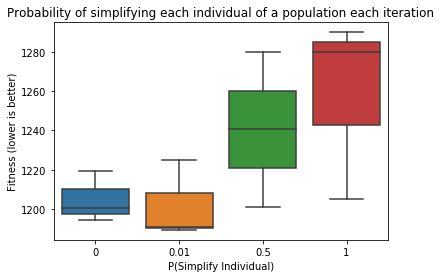

In [7]:
data = [
    v[0] for v in (p_simplify_results[k] 
        for k in sorted(p_simplify_results.keys()))
]

_ = boxplot(data=data).set(
    xlabel="P(Simplify Individual)",
    ylabel="Fitness (lower is better)",
    xticklabels=list(p_simplify_results.keys()),
    title="Probability of simplifying each individual of a population each iteration"
)

# Test Parameter: Probability of Mutating vs. Crossover

In [8]:
from test_runners import test_runner
start = time.perf_counter()

mutation_crossover_ratio_results = {}
for mutation_crossover_ratio in (0.2, 0.4, 0.6, 0.8):
    fitnesses = list(pool.imap_unordered(
        test_runner,
        ((run_test, {**args, "mutation_crossover_ratio": mutation_crossover_ratio}) for _ in range(ITERATIONS))
    ))
    stddev = stats.stdev(fitnesses)
    mean = stats.mean(fitnesses)
    mutation_crossover_ratio_results[mutation_crossover_ratio] = (fitnesses, stddev, mean)

print(f"Running {4 * ITERATIONS} tests at 20s each on {WORKERS} workers took {(time.perf_counter() - start):.1f}s")

Running 12 tests at 20s each on 8 workers took 80.2s


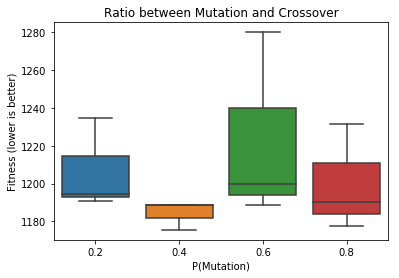

In [9]:
data = [
    v[0] for v in (mutation_crossover_ratio_results[k] 
        for k in sorted(mutation_crossover_ratio_results.keys()))
]

_ = boxplot(data=data).set(
    xlabel="P(Mutation)",
    ylabel="Fitness (lower is better)",
    xticklabels=list(mutation_crossover_ratio_results.keys()),
    title="Ratio between Mutation and Crossover"
)

In [14]:
# Clean up the worker threadpool.
pool.close()
pool.join()

# Other Possible Tests

In [10]:
# mutation_replacement_ratio_results = {}

# for mutation_replacement_ratio in (0, 0.25, 0.5, 0.75, 1):
#     fitnesses = [
#         run_test(**{**args, "mutation_replacement_ratio": mutation_replacement_ratio})
#         for _ in range(ITERATIONS)
#     ]
#     stddev = stats.stdev(fitnesses)
#     mean = stats.mean(fitnesses)
#     mutation_replacement_ratio_results[mutation_replacement_ratio] = (fitnesses, stddev, mean)

In [11]:
# num_sweeps_results = {}

# for num_sweeps in (0, 1, 2, 4, 8):
#     fitnesses = [
#         run_test(**{**args, "num_sweeps": num_sweeps})
#         for _ in range(ITERATIONS)
#     ]
#     stddev = stats.stdev(fitnesses)
#     mean = stats.mean(fitnesses)
#     num_sweeps_results[num_sweeps] = (fitnesses, stddev, mean)

In [12]:
# p_wrong_choice_results = {}

# for p_wrong_choice in (0, 0.1, 0.25, 0.4, 0.5):
#     fitnesses = [
#         run_test(**{**args, "wrong_choice": p_wrong_choice})
#         for _ in range(ITERATIONS)
#     ]
#     stddev = stats.stdev(fitnesses)
#     mean = stats.mean(fitnesses)
#     p_wrong_choice_results[p_wrong_choice] = (fitnesses, stddev, mean)